Step 1: download the data from eotdl

In [ ]:
import os
import zipfile
from eotdl.datasets import download_dataset

download_dataset("EuroSAT", version=1, path="data", force=True)

os.makedirs("data/EuroSAT", exist_ok=True)

with zipfile.ZipFile("data/EuroSAT/v1/EuroSAT.zip", 'r') as zip_ref:
    zip_ref.extractall("data/EuroSAT")

100%|██████████| 1.93G/1.93G [02:50<00:00, 12.1MiB/s]
100%|██████████| 1/1 [02:50<00:00, 170.71s/file]


'data/EuroSAT/v1'

Step 2: Make a random selection of labelled data for which we want to extract EO data, from the images we can readily extract their geospatial bounding box. We append this information into a dataframe which will lateron be used to orchestrate the EO data extraction.

In [27]:
import random
import rasterio
from shapely.ops import transform
from pyproj import Transformer
from shapely.geometry import Point, mapping
import geopandas as gpd
import pandas as pd
from utils import create_utm_patch, create_temporal_extent, get_tif_files, get_latlon_bbox

# Constants
SRC_DIR = r"C:\Git_projects\eotdl\data\EuroSAT\ds\images\remote_sensing\otherDatasets\sentinel_2\tif"
START_DATE = '2020-01-01'
NB_MONTHS = 3
NUM_FILES = 1
RESOLUTION = 20.0
DISTANCE_M = 320


def process_file(file, start_date, nb_months):
    """Process a single .tif file to extract required information."""
    with rasterio.open(file) as src:
        file_transform = src.transform
        crs = src.crs
        print(crs)
        width, height = src.width, src.height

        bbox_latlon = get_latlon_bbox(file_transform, crs, width, height)
        center_point = Point((bbox_latlon["west"] + bbox_latlon["east"]) / 2, 
                             (bbox_latlon["south"] + bbox_latlon["north"]) / 2)
        center_geom = gpd.GeoDataFrame(geometry=[center_point], crs="EPSG:4326")

        utm_patch, utm_crs = create_utm_patch(center_geom, distance_m=DISTANCE_M, resolution=RESOLUTION)
        transformer = Transformer.from_crs(utm_crs, "EPSG:4326", always_xy=True)
        latlon_patch = transform(transformer.transform, utm_patch)

        temporal_extent = create_temporal_extent(start_date, nb_months)

        return {
            "file_name": file,
            "bbox_latlon": bbox_latlon,
            "geometry": mapping(latlon_patch),
            "temporal_extent": temporal_extent
        }


# Get list of .tif files and select random sample
tif_files = get_tif_files(SRC_DIR)
selected_files = random.sample(tif_files, NUM_FILES)

# Process each selected file
data = [process_file(file, START_DATE, NB_MONTHS) for file in selected_files]

# Create a DataFrame from the data
df = pd.DataFrame(data)
print(df.iloc[0]['bbox_latlon'])
print(df.iloc[0]['geometry'])




EPSG:32631
{'west': 2.352592881371599, 'south': 48.70619958857077, 'east': 2.3613560038108927, 'north': 48.71199126311825, 'crs': 'EPSG:4326'}
{'type': 'Polygon', 'coordinates': (((2.3613644327896957, 48.712020399166995), (2.361437285280132, 48.70626327070295), (2.3527388370200555, 48.70621473211611), (2.3526649923068077, 48.71197185080745), (2.3613644327896957, 48.712020399166995)),)}


Step 2: Define the processing pipeline (Sentinel 2)

In [28]:
import openeo
from openeo.extra.job_management import (
        create_job_db,
        ProcessBasedJobCreator,
    )

job_db = create_job_db("jobs.csv", df)

connection = openeo.connect("openeofed.dataspace.copernicus.eu").authenticate_oidc()
process_graph_url = "https://raw.githubusercontent.com/ESA-APEx/apex_algorithms/main/openeo_udp/bap_composite.json"

#Make use of the Best Available Pixel openeo Process to obtain Sentinel 2 composites
job_starter = ProcessBasedJobCreator(
        namespace=process_graph_url,
        parameter_defaults={},
    )


Authenticated using refresh token.


In [29]:
from openeo.extra.job_management import MultiBackendJobManager

# Initiate MultiBackendJobManager 
job_manager = MultiBackendJobManager()  
connection = openeo.connect(url="openeofed.dataspace.copernicus.eu").authenticate_oidc()
job_manager.add_backend("cdse", connection=connection, parallel_jobs=10)


job_manager.run_jobs(job_db=job_db, start_job=job_starter)


Authenticated using refresh token.


defaultdict(int,
            {'job_db persist': 6,
             'track_statuses': 5,
             'job_db get_by_status': 1,
             'start_job call': 1,
             'job get status': 2,
             'job start': 1,
             'job launch': 1,
             'run_jobs loop': 5,
             'sleep': 5,
             'job describe': 4,
             'job started running': 1,
             'job finished': 1})

Image width: 64 pixels, Image height: 64 pixels
Image width: 64 pixels, Image height: 64 pixels


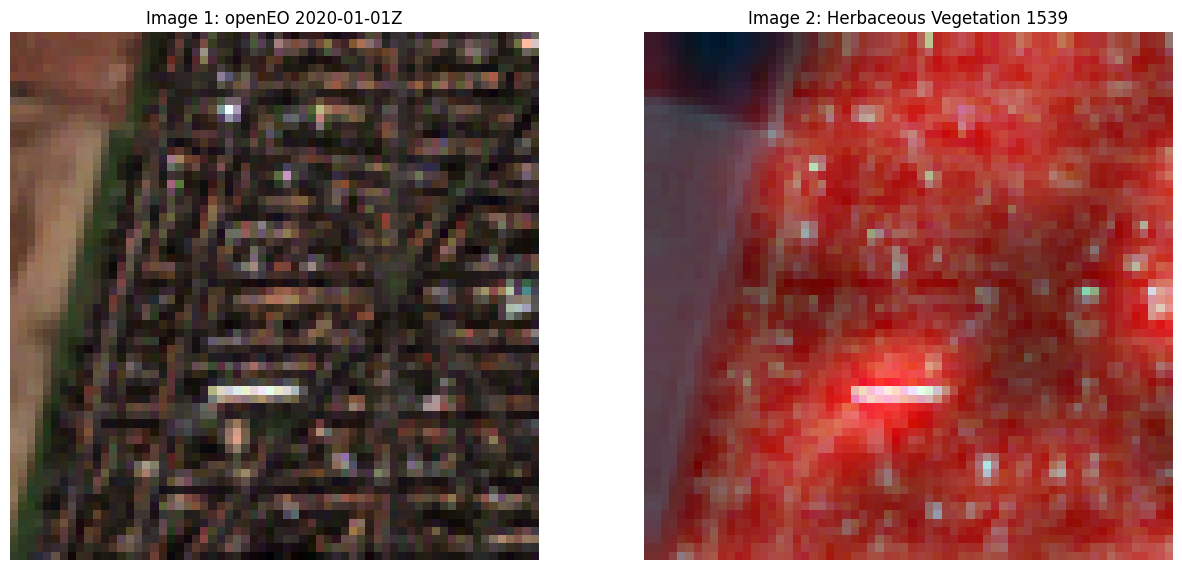

In [31]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt


# Define the paths to the two images
image_path1 = r"C:\Git_projects\eotdl\job_cdse-j-241107313355441090984aa82cf25583\openEO_2020-01-01Z.tif"
image_path2 = df.iloc[0]['file_name']

# Normalization function
def normalize(array):
    return (array - array.min()) / (array.max() - array.min())

# Function to load and normalize an RGB image
def load_rgb_image(path):
    with rasterio.open(path) as src:

        width, height = src.width, src.height
        print(f"Image width: {width} pixels, Image height: {height} pixels")
        # Read RGB bands (assuming the first three bands are RGB)
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)

        # Normalize each band
        red_norm = normalize(red)
        green_norm = normalize(green)
        blue_norm = normalize(blue)

        # Stack to create RGB image
        rgb_image = np.dstack((red_norm, green_norm, blue_norm))
    return rgb_image

# Load and normalize both images
rgb_image1 = load_rgb_image(image_path1)
rgb_image2 = load_rgb_image(image_path2)

# Plot the two images side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# Display first image
axs[0].imshow(rgb_image1)
axs[0].set_title("Image 1: openEO 2020-01-01Z")
axs[0].axis('off')

# Display second image
axs[1].imshow(rgb_image2)
axs[1].set_title("Image 2: Herbaceous Vegetation 1539")
axs[1].axis('off')

plt.show()

TODO:


- Scale up (saving data, improve efficiency, ...)

